<a href="https://colab.research.google.com/github/Rizvi999/neural-lab/blob/main/Welcome_To_Colab.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ==============================================
# FAST VGG16 TRANSFER LEARNING - CATS vs DOGS
# ==============================================

import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Dropout
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os, zipfile, shutil

# ==============================================
# STEP 1: DOWNLOAD & EXTRACT SMALL DATASET
# ==============================================
url = "https://storage.googleapis.com/mledu-datasets/cats_and_dogs_filtered.zip"
zip_path = tf.keras.utils.get_file("cats_and_dogs_filtered.zip", origin=url)

extract_path = os.path.join(os.path.dirname(zip_path), "cats_and_dogs_filtered")
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(os.path.dirname(zip_path))

train_dir = os.path.join(extract_path, "train")
val_dir = os.path.join(extract_path, "validation")

# ✅ OPTIONAL: Use only a small subset for speed
def reduce_dataset(source_dir, target_dir, max_images=500):
    os.makedirs(target_dir, exist_ok=True)
    for cls in os.listdir(source_dir):
        src_cls = os.path.join(source_dir, cls)
        dst_cls = os.path.join(target_dir, cls)
        os.makedirs(dst_cls, exist_ok=True)
        for i, img in enumerate(os.listdir(src_cls)):
            if i >= max_images:
                break
            shutil.copy(os.path.join(src_cls, img), os.path.join(dst_cls, img))

small_train = "cats_dogs_small/train"
small_val = "cats_dogs_small/val"
reduce_dataset(train_dir, small_train, max_images=500)
reduce_dataset(val_dir, small_val, max_images=250)

# ==============================================
# STEP 2: IMAGE DATA PIPELINE (128x128)
# ==============================================
train_datagen = ImageDataGenerator(rescale=1./255)
val_datagen = ImageDataGenerator(rescale=1./255)

train_gen = train_datagen.flow_from_directory(
    small_train,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'
)

val_gen = val_datagen.flow_from_directory(
    small_val,
    target_size=(128, 128),
    batch_size=16,
    class_mode='binary'
)

# ==============================================
# STEP 3: LOAD PRETRAINED VGG16 (FROZEN)
# ==============================================
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
for layer in base_model.layers:
    layer.trainable = False

# ==============================================
# STEP 4: BUILD FAST CLASSIFIER
# ==============================================
model = Sequential([
    base_model,
    Flatten(),
    Dense(128, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# ==============================================
# STEP 5: TRAIN QUICKLY (ONLY 2 EPOCHS)
# ==============================================
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=2,        # ⚡ small number of epochs for speed
    verbose=1
)

# ==============================================
# STEP 6: EVALUATE
# ==============================================
loss, acc = model.evaluate(val_gen)
print(f"✅ Validation Accuracy: {acc*100:.2f}%")

# ==============================================
# STEP 7: SAVE MODEL
# ==============================================
model.save("vgg16_fast_catsdogs.h5")
print("✅ Model saved as vgg16_fast_catsdogs.h5")


68606236/68606236 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Found 1000 images belonging to 2 classes.
Found 500 images belonging to 2 classes.
58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


/usr/local/lib/python3.12/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 332s 5s/step - accuracy: 0.6044 - loss: 0.6762 - val_accuracy: 0.8040 - val_loss: 0.4359
Epoch 2/2
63/63 ━━━━━━━━━━━━━━━━━━━━ 331s 5s/step - accuracy: 0.8060 - loss: 0.4263 - val_accuracy: 0.8380 - val_loss: 0.3736
32/32 ━━━━━━━━━━━━━━━━━━━━ 111s 3s/step - accuracy: 0.8425 - loss: 0.3585


✅ Validation Accuracy: 83.80%
✅ Model saved as vgg16_fast_catsdogs.h5


/tmp/ipython-input-1146036393.py:35: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128054 (\N{DOG FACE}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


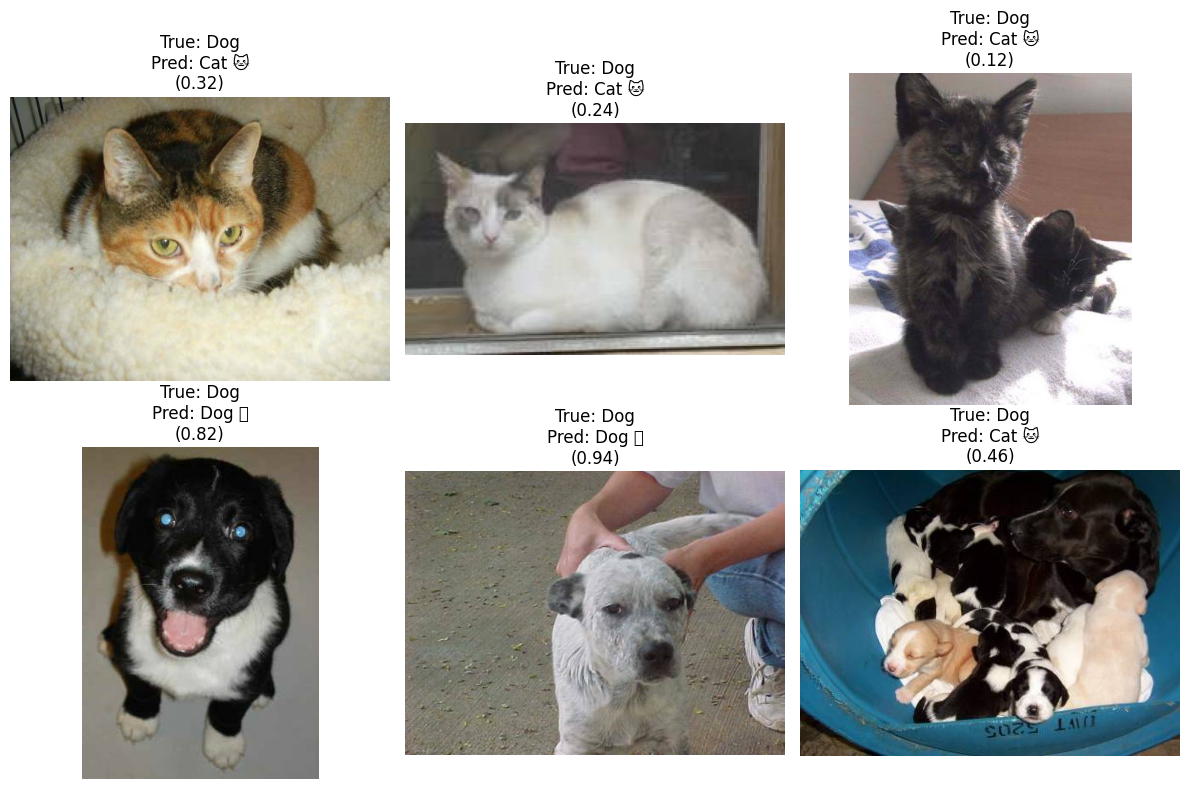

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import random
from tensorflow.keras.preprocessing import image

# Load the saved model
model = tf.keras.models.load_model("vgg16_fast_catsdogs.h5")

# Pick random images from validation set
val_cats = os.path.join(small_val, "cats")
val_dogs = os.path.join(small_val, "dogs")

# Select 5 random images (mix of cats and dogs)
sample_images = []
for folder in [val_cats, val_dogs]:
    sample_images += [os.path.join(folder, img) for img in random.sample(os.listdir(folder), 3)]

# Display predictions
plt.figure(figsize=(12, 8))

for i, img_path in enumerate(sample_images[:6]):
    img = image.load_img(img_path, target_size=(128, 128))
    img_array = image.img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    pred = model.predict(img_array, verbose=0)[0][0]
    pred_label = "Dog 🐶" if pred > 0.5 else "Cat 🐱"
    true_label = "Dog" if "dog" in img_path else "Cat"

    plt.subplot(2, 3, i + 1)
    plt.imshow(image.load_img(img_path))
    plt.axis("off")
    plt.title(f"True: {true_label}\nPred: {pred_label}\n({pred:.2f})")

plt.tight_layout()
plt.show()
